# Simulating compression for fully non-wetting droplet

<img src="Fig_S_force.png" style="width:300px">


This code calculates the shape of a droplet with known volume $V$ subjected to some force $F$. $2w$ is the contact size at the cantilever. Instructions on setting up python on your computer can be found in https://swcarpentry.github.io/2013-08-23-harvard/.

Libraries required:
1. numpy
2. matplotlib
3. scipy
4. seaborn


## Set up Jupyter notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.integrate import odeint
from scipy.optimize import newton, fsolve
from scipy.integrate import simps

import warnings
warnings.filterwarnings('ignore')

## Laplace equation

Non-dimensionalize all the quantities with respect by the droplet's width $2R$ and its surface tension $\gamma_{o}$ i.e. 

\begin{align}
\hat{F} &=  F \gamma_{o}^{-1} R^{-1} \\
\hat{r} &=  r R^{-1} \\
\hat{V} &=  V R^{-3} \\
\Delta \hat{P} &=  \Delta P R \gamma_{o}^{-1}, \mathrm{etc}
\end{align}

and hence, we get the non-dimensionalized Young-Laplace equation

\begin{align}
\frac{\hat{u}''}{(1+\hat{u}'^{2})^{3/2}} - \frac{1}{\hat{u}\sqrt{1 + \hat{u}'^{2}}}
&= -\Delta \hat{P}; \mathrm{for} \; \hat{z} \in (0, \hat{H}) \\
\end{align}

subject to the boundary conditions
\begin{align}
\hat{u}(0) &= \hat{r} \\
\hat{u}(\hat{H}) &= \hat{w} \\
\int_{0}^{\hat{H}} \pi \hat{u}^{2}d\hat{z} &= \hat{V} \\
\end{align}

and 

\begin{align}
\hat{F} &= \pi \hat{r}^{2}\Delta \hat{P}.  
\end{align}

Using the shooting method, we chose to frame the Young-Laplace equation as an initial value problem, with initial values

\begin{align}
\hat{u}(0) &= \hat{r} \\
\hat{u}'(0) &= 0,
\end{align}

while requiring that

$$\mathbf{\hat{m}}(\hat{r}, \Delta \hat{P}, \hat{\gamma}) =
\begin{pmatrix} \hat{u}(\hat{H})- \hat{w} \\ 
\int_{0}^{\hat{H}} \pi \hat{u}^{2}d\hat{z} - \hat{V}
\end{pmatrix} = 0$$.

This converts the boundary value problem into a root-finding problem of $\mathbf{\hat{m}}=0$, as implemented below

In [2]:
n_point = 10000  # number of points to plot droplet profile
slope_val = 1e5 # close to infinite
# u = [u, u', dP]
def ode(u, z):
    return np.array([u[1], (1+u[1]**2)**(1.5)*(1/(u[0]*np.sqrt(1+u[1]**2)) - u[2]), 0])  

# Calculate the residue 
def m_res(x, h_f, a):
    
    r = x[0]
    dP = x[1]
    
    z_arr = np.linspace(0, h_f, n_point)

    y_start = np.array([r, slope_val, dP])
    sol = odeint(ode, y_start, z_arr, atol=1e-10)
    u_arr = sol[:,0]
    dP_arr = sol[:,2]
    
#     u_arr_1 = u_arr[dP_arr == dP]
#     z_arr_1 = z_arr[dP_arr == dP]
#     V_int = simps(np.pi*u_arr_1**2, z_arr_1)
    V_int = simps(np.pi*u_arr**2, z_arr)
    u_h = u_arr[-1]
    
    return np.array([a-u_h, V_norm-V_int])
        
    
def calculate_sol(x, hf):
    r = x[0]
    dP = x[1]
    
    z_arr = np.linspace(0, hf, n_point)

    y_start = np.array([r, slope_val, dP])
    sol = odeint(ode, y_start, z_arr, atol=1e-10)
    u_arr = sol[:,0]
    dP_arr = sol[:,2]
    dP = dP_arr[0]
#     u_arr_1 = u_arr[dP_arr == dP]
#     z_arr_1 = z_arr[dP_arr == dP]
#     V_int = simps(np.pi*u_arr_1**2, z_arr_1)
    V_int = simps(np.pi*u_arr**2, z_arr)
    F_sol = dP*np.pi*r**2
    
    return z_arr, u_arr, dP, V_int, F_sol

# Example

Give a concrete example. Note that for a spherical cap, 
\begin{align}
V &=  \frac{\pi}{3}h^{2}(3R - h) = \frac{\pi}{6}h(3a^{2} + h^{2}) \\
h &= R + \sqrt{R^{2}-a^{2}}
\end{align}

In [3]:
# for a particular value of a_norm value
w_norm = 0.2
H_norm_i = 1.+np.sqrt(1-w_norm**2)
V_norm = np.pi/6*H_norm_i*(3*w_norm**2+H_norm_i**2)

H_norm = 0.98*H_norm_i
delta = H_norm_i-H_norm

# guess values (non-dimensionalized)
dP = 2.0                       
r0 = 0.05*np.sqrt(delta)

x_guess = np.array([r0, dP])

# root-finding solver, look for solution m=0
x_opt = fsolve(m_res, x_guess, args=(H_norm, w_norm))
print (m_res(x_opt, H_norm, w_norm))
print (x_opt)


[-2.30987451e-12  1.21680443e-13]
[0.09026932 2.00823882]


0.05140975529549324


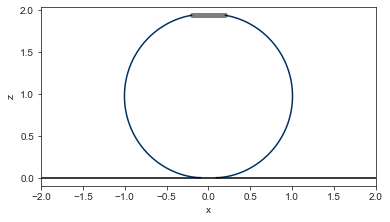

In [4]:
sns.set_style("ticks")
color_b = sns.xkcd_rgb["marine"]

z_sol, u_sol, p_sol, V_sol, F_sol = calculate_sol(x_opt, H_norm)
 
print (F_sol)
z_shift = 0. # shifting the base by 10 um

plt.plot(u_sol, z_sol+z_shift, color=color_b)
plt.plot(-u_sol, z_sol+z_shift, color=color_b)

plt.plot([-2, 2], [z_shift, z_shift], '-k') # plotting the base
plt.plot([-w_norm, w_norm], [H_norm+z_shift, H_norm+z_shift], '-k', alpha=0.5, lw=5)

plt.xlim([-2,2])
plt.xlabel("x")
plt.ylabel("z")

plt.axes().set_aspect('equal')

0.05140975529549324


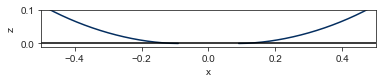

In [5]:
sns.set_style("ticks")
sns.set_style("ticks")
color_b = sns.xkcd_rgb["marine"]

z_sol, u_sol, p_sol, V_sol, F_sol = calculate_sol(x_opt, H_norm)
 
print (F_sol)
z_shift = 0 # shifting the base by 10 um

plt.plot(u_sol, z_sol+z_shift, color=color_b)
plt.plot(-u_sol, z_sol+z_shift, color=color_b)

plt.plot([-2, 2], [z_shift, z_shift], '-k') # plotting the base
plt.plot([-w_norm, w_norm], [H_norm+z_shift, H_norm+z_shift], '-k', alpha=0.5, lw=5)

plt.xlim([-0.5,0.5])
plt.ylim([-0.01, 0.1])
plt.xlabel("x")
plt.ylabel("z")

plt.axes().set_aspect('equal')


## Solving for different compression

In [6]:
H_i = 0.999*H_norm_i
H_f = 0.95*H_norm_i


dP = 2.0                       
r0 = 0.05*np.sqrt(delta)

H_arr = np.linspace(H_i, H_f, 200)

r_arr = np.array([]) 
P_arr = np.array([])
err_arr = np.array([])

x_guess = np.array([r0, dP])

for H_val in H_arr:
    
    H_norm = H_val
#     print H_norm
    #root-finding solver, look for solution m=0
    x_opt = fsolve(m_res, x_guess, args=(H_norm, w_norm))
    r_arr = np.append(r_arr, x_opt[0])
    P_arr = np.append(P_arr, x_opt[1])
    err_arr = np.append(err_arr, np.linalg.norm(m_res(x_opt, H_norm, w_norm)))
      
    x_guess = np.array([x_opt[0], x_opt[1]])

    

In [7]:
F_arr = np.pi*r_arr**2*P_arr

Numerical errors are small

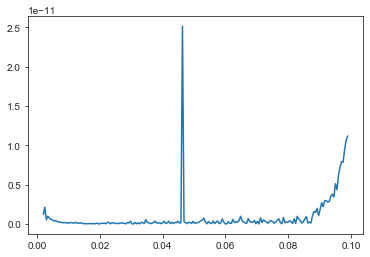

In [8]:
# error is small
plt.plot(H_norm_i-H_arr, err_arr)


# Find scaling

A good scaling fit is $\hat{F}$ = 1.9 $\hat{\delta}$ or in dimensionalized form $F$ = 1.9 $\gamma$ $R^{-0.1}$ $\delta^{1.1}$

In [9]:
a_fit = 1.9
b_fit = 1.11
# x_fit = np.linspace(1e-3, 5e-1)
F_fit = a_fit*d_arr**b_fit
plt.plot(d_arr, F_arr)
plt.plot(d_arr, F_fit, '--k', alpha=0.5)
plt.ylabel('Non-dimensional force')
plt.xlabel('Non-dimensional deformation')

NameError: name 'd_arr' is not defined